## Stackoverflow text-classifier

* [Github Repo](https://github.com/GoogleCloudPlatform/ai-platform-text-classifier-shap/blob/master/stackoverflow-classifier.ipynb)

* [Sara's Blog](https://sararobinson.dev/)

* [Youtube Video Tutorial](https://www.youtube.com/watch?v=OHIEZ-Scek8)

In [1]:
#!pip install tensorflow==1.13.1

In [2]:
import tensorflow as tf 
import pandas as pd
import numpy as np 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle

import pickle
import os
import numpy as np

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
!gsutil cp 'gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv' ./

Copying gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv...
- [1 files][276.7 MiB/276.7 MiB]                                                
Operation completed over 1 objects/276.7 MiB.                                    


In [4]:
file = os.path.join('.','SO_ml_tags_avocado_188k_v2.csv')
size = round(os.stat(file).st_size/(1024*1024))
print('File Size is {} MegaBytes '.format(size))

File Size is 277 MegaBytes 


In [5]:
!ls

dist		      processor_state.pkl     SO_ml_tags_avocado_188k_v2.csv
keras_saved_model.h5  __pycache__	      so_predict.egg-info
model_prediction.py   README.md		      text-classifier.ipynb
predictions.txt       setup.py
preprocess.py	      shap-interpreter.ipynb


In [6]:
data = pd.read_csv('SO_ml_tags_avocado_188k_v2.csv', names=['tags', 'original_tags', 'text'], header=0)
data = data.dropna()

In [7]:
data = data.drop(columns=['original_tags'])

In [8]:
#get rid of any order inherited from the table
data = shuffle(data, random_state = 22)

In [9]:
data.head()

,tags,text
182914,"tensorflow,keras",avocado image captioning model not compiling b...
48361,pandas,return excel file from avocado with flask in f...
181447,"tensorflow,keras",validating with generator (avocado) i'm trying...
66307,pandas,avocado multiindex dataframe selecting data gi...
11283,pandas,get rightmost non-zero value position for each...


In [10]:
data.iloc[0].text

'avocado image captioning model not compiling because of concatenate layer when mask_zero=true in a previous layer i am new to avocado and i am trying to implement a model for an image captioning project.   i am trying to reproduce the model from image captioning pre-inject architecture (the picture is taken from this paper: where to put the image in an image captioning generator) (but with a minor difference: generating a word at each time step instead of only generating a single word at the end), in which the inputs for the lstm at the first time step are the embedded cnn features. the lstm should support variable input length and in order to do this i padded all the sequences with zeros so that all of them have maxlen time steps.  the code for the model i have right now is the following:    def get_model(model_name, batch_size, maxlen, voc_size, embed_size,          cnn_feats_size, dropout_rate):      # create input layer for the cnn features     cnn_feats_input = input(shape=(cnn_f

## Feature Engineering

In [11]:
# Encode top tags to multi-hot
tags_split = [tags.split(',') for tags in data['tags'].values]
print(tags_split[0] )

['tensorflow', 'keras']


In [12]:
# One hot encoding
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(tag_encoder.classes_)

['keras' 'matplotlib' 'pandas' 'scikitlearn' 'tensorflow']


In [13]:
#label vector of the first row
tags_encoded[0]

array([1, 0, 0, 0, 1])

## Modeling

In [14]:
# Split our data into train and test sets from the label tags
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 150559
Test size: 37640


In [15]:
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

In [16]:
train_tags

array([[1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1]])



### **Creating a class to import in the future**
[Keras preprocessing text method](https://keras.io/preprocessing/text/)

In [17]:
%%writefile preprocess.py

# Pre-processing data: create our tokenizer class
from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
  def __init__(self, vocab_size):
    self._vocab_size = vocab_size
    self._tokenizer = None
  
  def create_tokenizer(self, text_list):
    """
    This class allows to vectorize a text corpus, by turning each text into either a sequence of 
    integers (each integer being the index of a token in a dictionary) or into a vector where the 
    coefficient for each token could be binary, based on word count, based on tf-idf.
    """
    tokenizer = text.Tokenizer(num_words=self._vocab_size)
    tokenizer.fit_on_texts(text_list)
    self._tokenizer = tokenizer

  def transform_text(self, text_list):
    text_matrix = self._tokenizer.texts_to_matrix(text_list)
    return text_matrix

Overwriting preprocess.py


In [18]:
# Create vocab from training corpus
from preprocess import TextPreprocessor

VOCAB_SIZE = 400 # This is a hyperparameter, try out different values for your dataset

In [19]:
#creating the train/test split
train_qs = data['text'].values[:train_size]
test_qs = data['text'].values[train_size:]

In [20]:
#initializing the class
processor = TextPreprocessor(VOCAB_SIZE)

In [21]:
#creating the matrix with the words size and the corpus of train qs
processor.create_tokenizer(train_qs)

In [22]:
#Creating the bag of words
body_train = processor.transform_text(train_qs)
body_test = processor.transform_text(test_qs)

In [23]:
#print the size of the matrix & the first vector of the corpus in train
print(len(body_train[0]))
print(body_train[0])

400
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0

## Build and train our model

In [24]:
# Save the processor state of the tokenizer
import pickle

with open('./processor_state.pkl', 'wb') as f:
  pickle.dump(processor, f)

In [25]:
# defining the neural net 

def create_model(vocab_size, num_tags):
    
    #Model groups layers into an object with training and inference features.
    model = tf.keras.models.Sequential()
    
    #Input shape = sizeof our matrix vector bag of words
    model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
    #A hidden layer to 25 nodes
    model.add(tf.keras.layers.Dense(25, activation='relu'))
    #Output layer to the number of tags that we want to predict
    model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [26]:
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                20050     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 130       
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Train

#_train = input bag of words's array
#_tags 
#epochs =  times where the model will iterate through the entire 
#batch size = how many elements the model will look at a time to update weights
#validation split = validation size 

model.fit(body_train, train_tags, epochs=3, batch_size=128, validation_split=0.1)


Train on 135503 samples, validate on 15056 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
135503/135503 [==============================] - 3s 24us/sample - loss: 0.1481 - acc: 0.9439 - val_loss: 0.1089 - val_acc: 0.9593
Epoch 2/3
135503/135503 [==============================] - 2s 17us/sample - loss: 0.1059 - acc: 0.9592 - val_loss: 0.1021 - val_acc: 0.9608
Epoch 3/3
135503/135503 [==============================] - 2s 17us/sample - loss: 0.0999 - acc: 0.9609 - val_loss: 0.0993 - val_acc: 0.9606


In [28]:
print('Eval loss/accuracy:{}'.format(
  model.evaluate(body_test, test_tags, batch_size=128)))

print('Eval loss/accuracy:{}'.format(model.evaluate(body_test, test_tags, batch_size=128)))

37640/37640 [==============================] - 0s 8us/sample - loss: 0.1012 - acc: 0.9603
Eval loss/accuracy:[0.10122975794149129, 0.9602978]
37640/37640 [==============================] - 0s 8us/sample - loss: 0.1012 - acc: 0.9603
Eval loss/accuracy:[0.10122975794149129, 0.9602978]


In [29]:
# Export the model to a file
model.save('keras_saved_model.h5')

## Test our model (locally)

1. Instantiate (the saved) model from the file,
2. Instantiate the tokenizer
3. preprocess the text data input text and transform 
4. Predict (the sigmoid probability array)

In [30]:
%%writefile model_prediction.py
import pickle
import os
import numpy as np

class CustomModelPrediction(object):

  def __init__(self, model, processor):
    self._model = model
    self._processor = processor
  
  def predict(self, instances, **kwargs):
    preprocessed_data = self._processor.transform_text(instances)
    predictions = self._model.predict(preprocessed_data)
    return predictions.tolist()

  @classmethod
  def from_path(cls, model_dir):
    import os
    import tensorflow.keras as keras
    model = keras.models.load_model(os.path.join(model_dir,'keras_saved_model.h5'))
    with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
      processor = pickle.load(f)

    return cls(model, processor)

Overwriting model_prediction.py


In [31]:
# Taking two external questions

test_requests = [
  "How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(['Hello', 'World']) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] ",
  "Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind='bar') plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name?"
]

In [32]:
from model_prediction import CustomModelPrediction

classifier = CustomModelPrediction.from_path('.')
model, processor

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f716aab7790>,
 <preprocess.TextPreprocessor at 0x7f7171851fd0>)

In [33]:
results = classifier.predict(test_requests)

In [34]:
results[0]

[0.9615075588226318,
 0.00011071562767028809,
 0.00018653273582458496,
 0.00030228495597839355,
 0.6557060480117798]

In [35]:
results[1]

[0.0001322627067565918,
 0.7257310152053833,
 0.8030164241790771,
 0.0004167031729593873,
 2.8905924409627914e-05]

In [36]:
for i in range(len(results)):
  print('Predicted labels for text-{}:'.format(i))
  for idx, val in enumerate(results[i]):
    if val > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

Predicted labels for text-0:
keras


Predicted labels for text-1:
matplotlib
pandas




## Package our model and deploy to AI Platform

In [37]:
%%writefile setup.py

from setuptools import setup

setup(
  name="so_predict",
  version="0.1",
  include_package_data=True,
  scripts=["preprocess.py", "model_prediction.py"]
)

Overwriting setup.py


In [38]:
#Copying model and preprocessor to GCS Bucket

!gsutil cp keras_saved_model.h5 gs://tex-classification-stackoverflow
!gsutil cp processor_state.pkl gs://tex-classification-stackoverflow

Copying file://keras_saved_model.h5 [Content-Type=application/octet-stream]...
/ [1 files][279.1 KiB/279.1 KiB]                                                
Operation completed over 1 objects/279.1 KiB.                                    
Copying file://processor_state.pkl [Content-Type=application/octet-stream]...
/ [1 files][ 32.0 MiB/ 32.0 MiB]                                                
Operation completed over 1 objects/32.0 MiB.                                     


### Source Distribution (or “sdist”)
A distribution format (usually generated using python setup.py sdist) that provides metadata and the essential source files needed for installing by a tool like pip, or for generating a Built Distribution.

In [39]:
!python setup.py sdist
!gsutil cp ./dist/so_predict-0.1.tar.gz gs://tex-classification-stackoverflow/packages/so_predict-0.1.tar.gz

running sdist
running egg_info
writing so_predict.egg-info/PKG-INFO
writing dependency_links to so_predict.egg-info/dependency_links.txt
writing top-level names to so_predict.egg-info/top_level.txt
reading manifest file 'so_predict.egg-info/SOURCES.txt'
writing manifest file 'so_predict.egg-info/SOURCES.txt'
running check


creating so_predict-0.1
creating so_predict-0.1/so_predict.egg-info
creating so_predict-0.1/so_predict.egg-info/.ipynb_checkpoints
copying files to so_predict-0.1...
copying README.md -> so_predict-0.1
copying model_prediction.py -> so_predict-0.1
copying preprocess.py -> so_predict-0.1
copying setup.py -> so_predict-0.1
copying so_predict.egg-info/PKG-INFO -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/SOURCES.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/dependency_links.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/top_level.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/.ip

In [40]:
# To configure and give access to the API
#!glcloud init

To review details visit https://cloud.google.com/ai-platform/prediction/docs/deploying-models#gcloud

In [41]:
!gcloud config set project text-classification-272101

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [42]:
!gcloud ai-platform models create pred_stacko_tags --regions us-east1

ERROR: (gcloud.ai-platform.models.create) Resource in project [text-classification-272101] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


https://cloud.google.com/ai-platform/prediction/docs/custom-prediction-routines

In [43]:
!gcloud beta ai-platform versions create v1 \
--model pred_stacko_tags \
--python-version 3.5 \
--runtime-version 1.13 \
--origin gs://tex-classification-stackoverflow/ \
--package-uris gs://tex-classification-stackoverflow/packages/so_predict-0.1.tar.gz \
--prediction-class model_prediction.CustomModelPrediction

ERROR: (gcloud.beta.ai-platform.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


# Generating predictions in our deployed trained model

In [44]:
# https://stackoverflow.com/questions/55517871/how-to-preprocess-strings-in-keras-models-lambda-layer
# https://stackoverflow.com/questions/55508547/plot-histogram-for-feature-of-array-with-known-and-limited-values

In [45]:
%%writefile predictions.txt
"How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error"
"I have a test excel file like:df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]})print (df)name  age0    a   101    b   202    c    53    d   234    e   585    f    46    g    6I use Pandas and matplotlib to read and plot it:import pandas as pdimport numpy as npimport matplotlib.pyplot as pltimport osexcel_file = 'test.xlsx'df = pd.read_excel(excel_file, sheet_name=0)df.plot(kind='bar')plt.show()the result shows: enter image description hereit use index number as item name, how can I change it to the name, which stored in column name?"

Overwriting predictions.txt


In [46]:
# Getting predictions for our model
predictions = !gcloud ai-platform predict --model=pred_stacko_tags --version=v1 --text-instances=predictions.txt 

In [47]:
predictions

['[[0.5516136288642883, 0.0020238757133483887, 0.007797569036483765, 0.024999558925628662, 0.6891115307807922], [2.9295682907104492e-05, 0.6664252281188965, 0.8341155052185059, 8.279687608592212e-05, 5.1649301894940436e-05]]']

In [48]:
for sigmoid_arr in eval(predictions[0]):
  print(sigmoid_arr)
  for idx,probability in enumerate(sigmoid_arr):
    if probability > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

[0.5516136288642883, 0.0020238757133483887, 0.007797569036483765, 0.024999558925628662, 0.6891115307807922]


[2.9295682907104492e-05, 0.6664252281188965, 0.8341155052185059, 8.279687608592212e-05, 5.1649301894940436e-05]
pandas




In [50]:
print(tag_encoder.classes_, '\n')

for sigmoid_arr in eval(predictions[0]):
  print(sigmoid_arr)
  for idx,probability in enumerate(sigmoid_arr):
    if probability > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

['keras' 'matplotlib' 'pandas' 'scikitlearn' 'tensorflow'] 

[0.5516136288642883, 0.0020238757133483887, 0.007797569036483765, 0.024999558925628662, 0.6891115307807922]


[2.9295682907104492e-05, 0.6664252281188965, 0.8341155052185059, 8.279687608592212e-05, 5.1649301894940436e-05]
pandas




# Interpreting our model with SHAP

In [49]:
import shap
attrib_data = body_train[:200]
explainer = shap.DeepExplainer(model, attrib_data)

num_explanations = 25
shap_vals = explainer.shap_values(body_test[:num_explanations])

In [69]:
body_test[:25]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [64]:
words = processor._tokenizer.word_index
dict(list(words.items())[0:10])

{'0': 1,
 'the': 2,
 'avocado': 3,
 'i': 4,
 '1': 5,
 'to': 6,
 'a': 7,
 'in': 8,
 '2': 9,
 'and': 10}

In [66]:
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
print(word_lookup[:100])

['', '0', 'the', 'avocado', 'i', '1', 'to', 'a', 'in', '2', 'and', 'is', 'of', 'for', '3', 'x', 'data', 'this', 'with', 'df', 'as', '5', 'it', 'import', '4', 'from', 'gt', 'y', 'that', 'have', 'model', 'dataframe', 'file', 'self', 'but', '00', "'", 'my', 'on', 'np', '10', 'train', 'how', 'python', 'if', 'not', 'get', '7', 'line', '6', '01', 'be', 'like', 'lt', 'using', 'c', 'nan', 'am', 'column', 'py', 'name', 'code', 'input', 'index', 'values', 'can', 'size', 'do', 'plot', 'print', 'columns', 'b', 'so', 'value', 'lib', 'shape', 'set', '8', 'test', 'want', 'error', 'are', 'output', 'an', 'true', 'packages', '12', 'use', 'time', 'n', 'batch', 'return', 'or', 'add', 'by', 'def', 'would', 'list', 'when', '9']


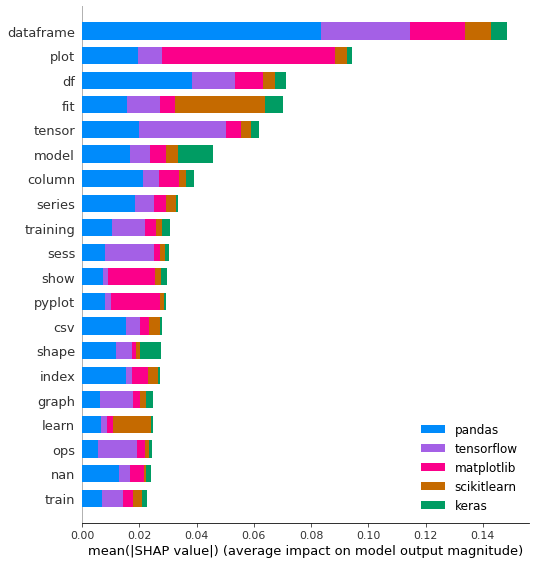

In [67]:
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)